In [9]:

import numpy as np
import torch
import matplotlib.pyplot as plt

import seaborn as sns

In [10]:
max_t = 75

np.random.seed(5)

In [11]:
def input_to_tensor(u):
    s = u.reshape(u.shape[0], u.shape[1], 1)
    return torch.from_numpy(s)

def output_to_tensor(y, time_steps=1):
    y_ = np.ones()

    return torch.from_numpy(y.reshape(-1,time_steps))   

def random_shuffle(dataset, batch_size):
    n_trial = dataset['y'].shape[0]

    perm = np.random.permutation(n_trial)
    
    num_batch = n_trial // batch_size

    in_list = []
    out_list = []

    for i in range(num_batch):
        idx = perm[i*batch_size:(i+1)*batch_size]

        us = dataset['u'][:,idx]
        ys = dataset['y'][idx].astype(np.float32)

        in_list.append(us.copy())
        out_list.append(ys.copy())

    return num_batch, in_list, out_list

In [12]:
def generate_dataset_2(num_trial, t=75, delay = 50):
    set = [10,14,18,22,26,30,34]

    f_min = 10
    f_max = 34
    
    f1 = np.random.choice(set, size=num_trial)
    f2 = np.random.choice(set, size=num_trial)
    
    u1 = (1 / (f_max - f_min))*(f1 - 0.5*(f_max + f_min))
    u2 = (1 / (f_max - f_min))*(f2 - 0.5*(f_max + f_min))

    u = np.zeros((t, num_trial))

    win1 = [5, 10]
    win2 = [win1[1] + delay, win1[1]+ delay + 10]

    for i in range(num_trial):
        u[win1[0]:win1[1], i] = u1[i]
        u[win2[0]:win2[1], i] = u2[i]

    y = (f1 - f2)/ (f_max-f_min)
    

    r_dict = {'u':u.astype(np.float32), 'y':y.astype(np.float32)}    
    return r_dict

In [13]:
class LowRankRNN2(torch.nn.Module):
    def __init__(self, N, del_t, tau, rank=2):
        super(LowRankRNN2, self).__init__()

        self.m1 = torch.nn.Parameter(torch.normal(0, 0.05, (N, rank)))
        self.m2 = torch.nn.Parameter(torch.normal(0, 0.05, (N, rank)))
        
        self.n1 = torch.nn.Parameter(torch.normal(0, 0.05, (rank, N)))
        self.n2 = torch.nn.Parameter(torch.normal(0, 0.05, (rank, N)))
        
        #self.ms = []
        #self.ns = []

        ##for i in range(rank):
        #   self.ms.append(torch.nn.Parameter(torch.normal(0, 0.05, (N, 1))))
        #   self.ns.append(torch.nn.Parameter(torch.normal(0, 0.05, (1, N))))

        self.I = torch.nn.Parameter(torch.normal(0, 0.05, (1, N)))
        self.w = torch.nn.Parameter(torch.normal(0, 0.05, (N, 1)))

        # self.j = torch.nn.Parameter(torch.normal(0, 0.05, (N, N)))
        # self.j.requires_grad = True

        self.time_mul = del_t / tau

        self.N = N


    def forward(self, u, x): # u->(batch, 1), x->(batch, N) 

        # print(j)
        # for i in range(self.rank):
        #     j = torch.add(j, torch.mm(self.ms[i], self.ns[i]))
        #     print(j)
        
        j1 = torch.mm(self.m1, self.n1)
        j2 = torch.mm(self.m2, self.n2)

        j = torch.add(j1, j2)
        j = torch.div(j, 2*self.N)

        a = torch.tanh(x)
        a = torch.matmul(a, j) # -> (batch, N)

        # a = torch.tanh(x_t)
        # a = torch.matmul(self.j, a) # -> (N, batch)

        b = torch.mm(u, self.I) # -> (batch, N)

        c = torch.add(a, b)
        c = torch.sub(c, x)
        c = torch.mul(c, self.time_mul)

        xx = torch.add(x, c) # -> (batch, N)
        
        out = torch.mm(xx, self.w) #->(batch, 1)
        out  = torch.div(out, self.N)
        return out, xx

    def init_x(self, batch_size=16):
        return torch.normal(0, 0.05, (batch_size, self.N))

In [141]:
def training2(lr=5e-3, num_epochs=10, n_trial = 16, batch_size=8, N=128, T=5, t_step=max_t, min_delay=25, max_delay=50):
    # Low rank RNN params
    tau = 100e-3
    del_t = 20e-3

    # Autograd Params
    lr = 5e-3
    rnn = LowRankRNN2(N, del_t, tau, 1)

    m = torch.nn.Sigmoid()

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

    delays = np.arange(min_delay, max_delay, step=1)

    datasets = []
    for delay in (delays):
        datasets.append(generate_dataset_2(num_trial=n_trial, t=t_step,delay=delay))
        
    loss_log = []
    for dataset in datasets:
        for epoch in range(num_epochs):
            num_batch, in_list, out_list = random_shuffle(dataset, batch_size)

            for i in range(num_batch):
                x_past = rnn.init_x(batch_size)
                in_tensor = input_to_tensor(in_list[i])
                out_tensor = output_to_tensor(out_list[i])
                
                outs = []
                loss_sum = 0
                for j in range(t_step):
                    out, x_past = rnn(in_tensor[j,:,:], x_past)
                    outs.append(out)

                    # if j >= (t_step - T):
                    #     loss = criterion(out, out_tensor)
                    #     optimizer.zero_grad()
                    #     loss.backward(retain_graph=True)
                    #     optimizer.step()
                    #     loss_sum  += loss.item()

                # loss_sum = 0

                for j in range(-5, 0):    
                    loss = criterion(outs[j], out_tensor)  
                    optimizer.zero_grad()              
                    loss.backward(retain_graph=True)
                    optimizer.step()
                    loss_sum  += loss.item()
                
                loss_log.append(loss_sum/(T))

            # loss = criterion(outs[j], out_tensor)
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            # loss_log.append(loss.item())
           
            if epoch % int(num_epochs*0.1) == 0:
                print('loss: {}'.format(loss_log[-1]))
            # if loss_log[-1]<5e-2:
            #    break

    return rnn


In [160]:
rnn2 = training2(n_trial=256, batch_size=32, num_epochs=200, min_delay=50, max_delay=51)

loss: 0.16956888735294343


KeyboardInterrupt: 

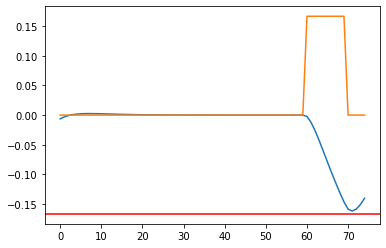

In [159]:
dataset = generate_dataset_2(num_trial=1)
num_batch, in_list, out_list = random_shuffle(dataset, 1)
x_past = rnn2.init_x(1)
outs = []
for i in range(max_t):
    in_tensor = torch.from_numpy(dataset['u'][i].reshape(1,1))
    out, x_past = rnn2.forward(in_tensor, x_past)
    outs.append(out.detach().numpy())

outs= np.array(outs).ravel()

plt.plot(outs)
plt.axhline(dataset['y'][0], color='red')
plt.plot(dataset['u'])

plt.show()